In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import pandas as pd

In [18]:
df = sns.load_dataset('tips')
X = df.drop('total_bill', axis=1)
y = df['total_bill']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [21]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=False))  # 👈 Fix
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [22]:
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [23]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [24]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = pipe.predict(X_test)

print("✅ R² Score on Test Set:", r2_score(y_test, y_pred))
print("✅ MSE on Test Set:", mean_squared_error(y_test, y_pred))


✅ R² Score on Test Set: 0.48836534081988325
✅ MSE on Test Set: 43.38075778113304


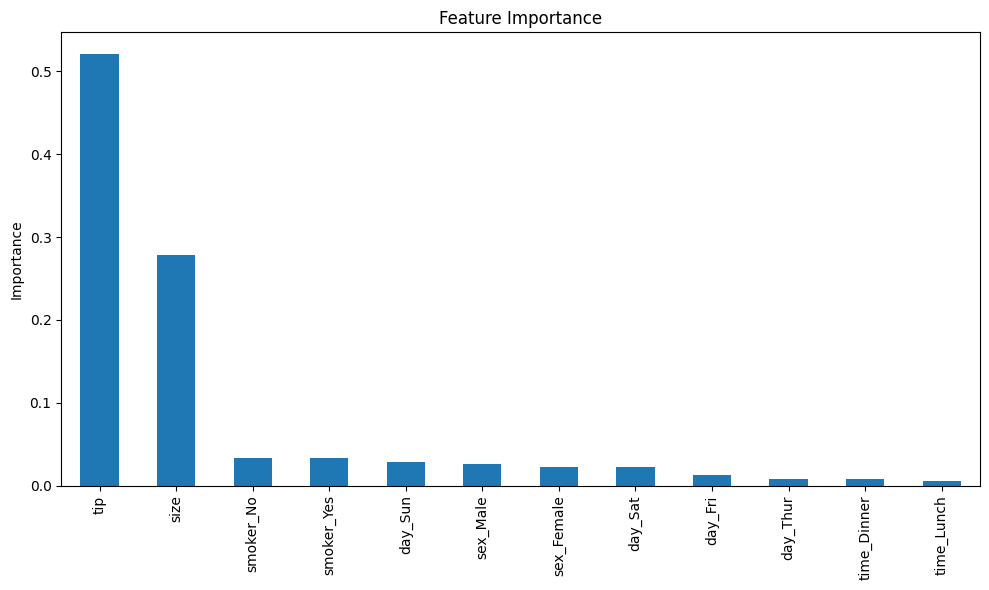

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names
cat_features = pipe.named_steps['preprocessor'].named_transformers_['cat'] \
                 .named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

# Get feature importances
importances = pipe.named_steps['regressor'].feature_importances_
feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Score:", grid_search.best_score_)

# Evaluate best model
y_pred = grid_search.best_estimator_.predict(X_test)
print("✅ Test R² Score:", r2_score(y_test, y_pred))


✅ Best Parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
✅ Best CV Score: 0.4385282713399796
✅ Test R² Score: 0.5269713273180101
